In [1]:
import pandas as pd
from plotnine import *
from datetime import datetime
import numpy as np
import itertools

In [2]:
github_incidents = pd.read_parquet('./github_failures_2019-20').reset_index(drop=True)
or_events = pd.read_parquet('./outage_report_2019-20')

In [3]:
github_incidents['start_time'] = pd.to_datetime(github_incidents['event_start_time'], unit='s')
github_incidents['end_time'] = pd.to_datetime(github_incidents['event_end_time'], unit='s')

github_filter_mask = (github_incidents['event_start_time'] != -1) & (github_incidents['event_end_time'] != -1)
filtered_github_incidents = github_incidents[github_filter_mask].reset_index(drop=True)

In [4]:
# Need to incorporate these later. IMPORTANT
github_incidents.loc[~github_filter_mask].reset_index(drop=True)

,status,event_start_time,event_end_time,vendor,start_time,end_time
0,,-1,-1,,1969-12-31 23:59:59,1969-12-31 23:59:59
1,\n\n\n\nResolved -\n \t2019-05-07 10:35 U...,-1,1557225300,Github,1969-12-31 23:59:59,2019-05-07 10:35:00
2,\n\n\n\nResolved -\n \tWebhook deliveries...,-1,1585641600,Github,1969-12-31 23:59:59,2020-03-31 08:00:00
3,\n\n\n\nResolved -\n \tWe have identified...,-1,1586352600,Github,1969-12-31 23:59:59,2020-04-08 13:30:00


In [5]:
# Investigating the lack of critical event from September 2019
filtered_github_incidents[(filtered_github_incidents['start_time'].dt.year == 2019) & (filtered_github_incidents['start_time'].dt.month == 9)]

,status,event_start_time,event_end_time,vendor,start_time,end_time
1,minor,1569502020,1569506460,Github,2019-09-26 12:47:00,2019-09-26 14:01:00
3,minor,1569324600,1569334080,Github,2019-09-24 11:30:00,2019-09-24 14:08:00
4,critical,1569255120,1569256620,Github,2019-09-23 16:12:00,2019-09-23 16:37:00


In [133]:
# Check ICPE article as we missed events shorter than an hour

In [6]:
# I checked outage report code and timestamps are in UTC
filtered_or_events = or_events[or_events['status_code'] >= 0].reset_index(drop=True)
filtered_or_events = filtered_or_events.drop_duplicates(subset=['vendor', 'event_time', 'status_code'])
# Combine events with the same event_time, but different status_code with max
filtered_or_events = filtered_or_events.groupby(['vendor', 'event_time'])['status_code'].max().reset_index()
filtered_or_events['evtime'] = pd.to_datetime(filtered_or_events['event_time'], unit='s')
or_github = filtered_or_events[(filtered_or_events['vendor'] == 'github')].reset_index(drop=True)
or_github.shape

(39195, 4)

In [15]:
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
first_day_of_month = list(itertools.accumulate(days_per_month, initial=1))
first_day_of_month_for_two_years = list(itertools.accumulate(days_per_month + days_per_month, initial=1))
first_day_of_month_for_two_years

[1,
 32,
 60,
 91,
 121,
 152,
 182,
 213,
 244,
 274,
 305,
 335,
 366,
 397,
 425,
 456,
 486,
 517,
 547,
 578,
 609,
 639,
 670,
 700,
 731]

In [33]:
all_or_github_count = 0
filtered_or_github_count = 0
grid_array = np.full((365*2, 24), 0)
for _, row in or_github.sort_values('evtime').iterrows():
    year_of_event = row['evtime'].year
    day_of_year = row['evtime'].timetuple().tm_yday
    hour_of_day = row['evtime'].hour
    num_reports = row['status_code']
    if num_reports > 2:
        if year_of_event == 2019:
            grid_array[day_of_year-1, hour_of_day-1] = 1
        elif year_of_event == 2020:
            grid_array[365+day_of_year-1, hour_of_day-1] = 1
        else:
            raise Exception('Unknown year: ' + str(year_of_event))
            
        filtered_or_github_count += num_reports
    all_or_github_count += num_reports

or_github_grid_df = pd.DataFrame({
    'day_of_year': np.repeat(np.tile(np.arange(1, 365+1), 2), 24),
    'hour_of_day': np.tile(np.arange(1, 24+1), 365*2),
    'year': np.concatenate([np.repeat(2019, 365*24), np.repeat(2020, 365*24)]),
    'status': grid_array.flatten()
})

unified_or_github_grid_df = or_github_grid_df[((or_github_grid_df['year'] == 2019) & (or_github_grid_df['day_of_year'] > 31+28+31+30))
                                             | ((or_github_grid_df['year'] == 2020) & (or_github_grid_df['day_of_year'] < 365-31-30-31-30))].reset_index(drop=True)

unified_or_github_grid_df['day_of_two_years'] = unified_or_github_grid_df['day_of_year']
unified_or_github_grid_df.loc[(unified_or_github_grid_df['year'] == 2020), 'day_of_two_years'] = unified_or_github_grid_df.loc[(unified_or_github_grid_df['year'] == 2020), 'day_of_two_years'] + 365

# Reports used for github comparison
print(all_or_github_count)
print(filtered_or_github_count)

4432.0
2974.0


In [9]:
def make_grid(df):
    status_to_number_map = {
#         'maintenance': 1,
        'minor': 1,
        'major': 2,
        'critical': 3,
    }
    
    # First make and populate 2D grid array
    grid_array = np.full((365*2, 24), 0)
    for _, row in df.sort_values('start_time').iterrows():
        year_of_event = row['start_time'].year
        start_day_of_year = row['start_time'].timetuple().tm_yday
        start_hour_of_day = row['start_time'].hour
        end_day_of_year = row['end_time'].timetuple().tm_yday
        end_hour_of_day = row['end_time'].hour
        
        offset = 0
        if year_of_event == 2019:
            offset = 0
        elif year_of_event == 2020:
            offset = 365
        else:
            raise Exception('Unknown year: ' + str(year_of_event))
        
        for day_of_year in range(start_day_of_year, end_day_of_year+1):
            if start_day_of_year == end_day_of_year: # less than a day
                for hour_of_day in range(start_hour_of_day, end_hour_of_day+1):
                    grid_array[offset+day_of_year-1, hour_of_day-1] = status_to_number_map[row['status']]
            elif day_of_year == start_day_of_year: # first day
                for hour_of_day in range(start_hour_of_day, 25):
                    grid_array[offset+day_of_year-1, hour_of_day-1] = status_to_number_map[row['status']]
            elif day_of_year == end_day_of_year: # last day
                for hour_of_day in range(0, end_hour_of_day):
                    grid_array[offset+day_of_year-1, hour_of_day-1] = status_to_number_map[row['status']]
            else: # middle day
                for hour_of_day in range(1, 25):
                    grid_array[offset+day_of_year-1, hour_of_day-1] = status_to_number_map[row['status']]
        
    return grid_array

In [10]:
github_grid_array = make_grid(filtered_github_incidents)
github_grid_df = pd.DataFrame({
    'day_of_year': np.repeat(np.tile(np.arange(1, 365+1), 2), 24),
    'hour_of_day': np.tile(np.arange(1, 24+1), 365*2),
    'year': np.concatenate([np.repeat(2019, 365*24), np.repeat(2020, 365*24)]),
    'status': pd.Categorical(github_grid_array.flatten(), [0,1,2,3], ordered=True)
})

unified_github_grid_df = github_grid_df[((github_grid_df['year'] == 2019) & (github_grid_df['day_of_year'] > 31+28+31+30))
                                             | ((github_grid_df['year'] == 2020) & (github_grid_df['day_of_year'] < 365-31-30-31-30))].reset_index(drop=True)

unified_github_grid_df['day_of_two_years'] = unified_github_grid_df['day_of_year']
unified_github_grid_df.loc[(unified_github_grid_df['year'] == 2020), 'day_of_two_years'] = unified_github_grid_df.loc[(unified_github_grid_df['year'] == 2020), 'day_of_two_years'] + 365

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 25 x 2 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/github_failures_all.pdf


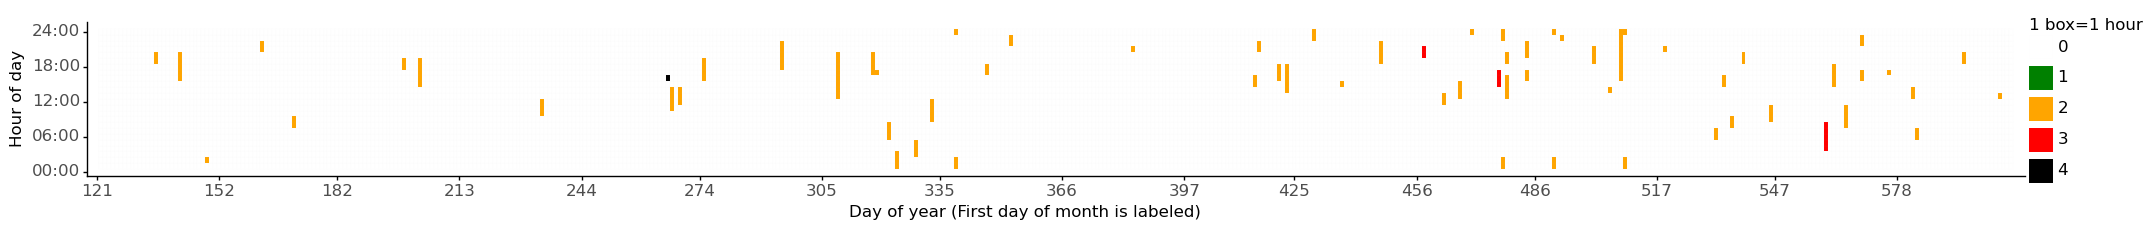

<ggplot: (326298676)>

In [70]:
plt = ggplot(unified_github_grid_df) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    geom_tile(mapping=aes(x='day_of_two_years', y='hour_of_day', fill='status'), color='gainsboro', size=0.01) +\
    scale_fill_manual(values=['white', 'green', 'orange', 'red', 'black']) +\
    scale_x_continuous(limits=(first_day_of_month_for_two_years[4], first_day_of_month_for_two_years[-5]-1), expand=(0.005, 0.005),
                       breaks=first_day_of_month_for_two_years[4:-5]) +\
    scale_y_continuous(breaks=[0, 6, 12, 18, 24],
                       labels=['00:00', '06:00', '12:00', '18:00', '24:00']) +\
    theme(figure_size=(25, 2)) +\
    guides(fill=guide_legend(title='1 box=1 hour')) +\
    ylab('Hour of day') +\
    xlab('Day of year (First day of month is labeled)') +\
    theme(legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          text=element_text(size=12))

# scale_x_continuous(limits=(0, 365), expand=(0.005, 0.005),
#                        breaks=[31, 59, 90, 120, 151, 180, 211, 242, 272, 303, 333, 364],
#                        labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) +\

plt.save('plots/github_failures_all.pdf', limitsize=False)
plt

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 25 x 2 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/or_github_failures.pdf
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log


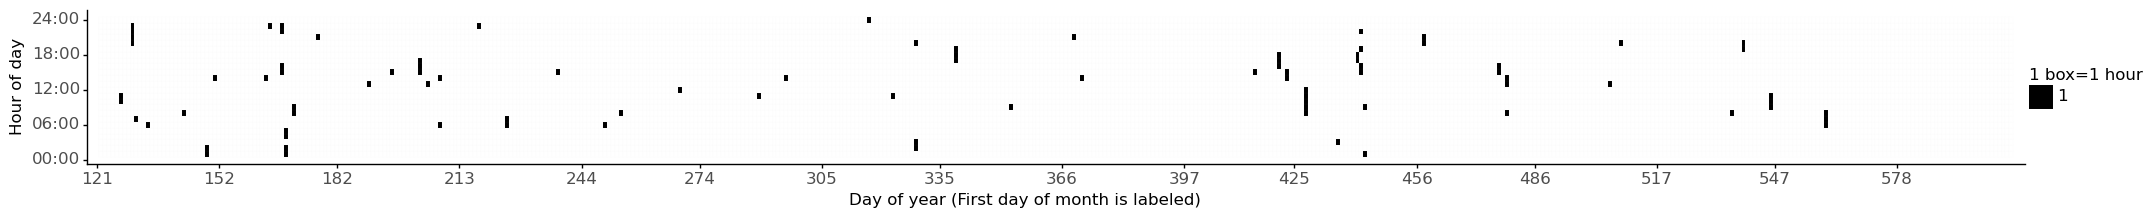

<ggplot: (337549840)>

In [71]:
plt = ggplot(unified_or_github_grid_df) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    geom_tile(mapping=aes(x='day_of_two_years', y='hour_of_day', fill='status'), color='gainsboro', size=0.01) +\
    scale_fill_continuous('Greys', trans="log") +\
    scale_x_continuous(limits=(first_day_of_month_for_two_years[4], first_day_of_month_for_two_years[-5]-1), expand=(0.005, 0.005),
                       breaks=first_day_of_month_for_two_years[4:-5]) +\
    scale_y_continuous(breaks=[0, 6, 12, 18, 24],
                       labels=['00:00', '06:00', '12:00', '18:00', '24:00']) +\
    theme(figure_size=(25, 2)) +\
    guides(fill=guide_legend(title='1 box=1 hour')) +\
    ylab('Hour of day') +\
    xlab('Day of year (First day of month is labeled)') +\
    theme(legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          text=element_text(size=12))

plt.save('plots/or_github_failures.pdf', limitsize=False)
plt

In [72]:
assert(unified_github_grid_df.shape[0] == unified_or_github_grid_df.shape[0])

In [14]:
def merge_dfs(github_df, github_or_df):
    list_of_merged_rows = []
    for i in range(github_df.shape[0]):
        github_status = github_df.loc[i, 'status']
        or_github_status = github_or_df.loc[i, 'status']

        final_status = github_status

        if or_github_status == 1:
            if github_status == 0:
                final_status = 4
            elif github_status == 1:
                final_status = 5
            elif github_status == 2:
                final_status = 6
            else:
                raise Exception('Unknown github status')

        list_of_merged_rows.append({
            'status': final_status,
            'hour_of_day': github_df.loc[i, 'hour_of_day'],
            'year': github_df.loc[i, 'year'],
            'day_of_year': github_df.loc[i, 'day_of_year'],
            'day_of_two_years': github_df.loc[i, 'day_of_two_years']
        })

    merged_df = pd.DataFrame(list_of_merged_rows)
    merged_df['status'] = pd.Categorical(merged_df['status'], [0,1,2,3,4,5,6], ordered=True)
    return merged_df

merged_df = merge_dfs(unified_github_grid_df, unified_or_github_grid_df)

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 25 x 2 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/github_merged_failures.pdf


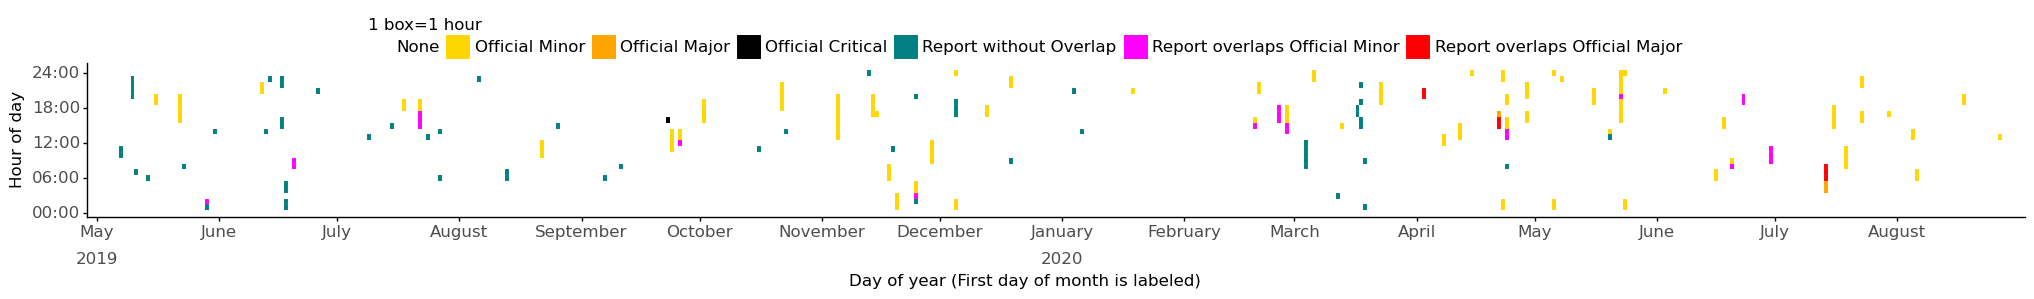

<ggplot: (339631818)>

In [114]:
plt = ggplot(merged_df) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    geom_tile(mapping=aes(x='day_of_two_years', y='hour_of_day', fill='status'), color='white', size=0.02) +\
    scale_fill_manual(values=['white', 'gold', 'orange', 'black', 'teal', 'magenta', 'red'],
                      labels=['None', 'Official Minor', 'Official Major', 'Official Critical', 'Report without Overlap', 'Report overlaps Official Minor', 'Report overlaps Official Major']) +\
    scale_x_continuous(limits=(first_day_of_month_for_two_years[4], first_day_of_month_for_two_years[-5]-1), expand=(0.005, 0.005),
                       breaks=first_day_of_month_for_two_years[4:-5],
                       labels=['May\n\n2019', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January\n\n2020', 'February', 'March', 'April', 'May', 'June', 'July', 'August']) +\
    scale_y_continuous(breaks=[0, 6, 12, 18, 24],
                       labels=['00:00', '06:00', '12:00', '18:00', '24:00']) +\
    theme(figure_size=(25, 2)) +\
    guides(fill=guide_legend(title='1 box=1 hour', nrow=1)) +\
    ylab('Hour of day') +\
    xlab('Day of year (First day of month is labeled)') +\
    theme(legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          legend_position='top',
          text=element_text(size=12))

plt.save('plots/github_merged_failures.pdf', limitsize=False)
plt

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 16 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/double_github_merged_failures.pdf


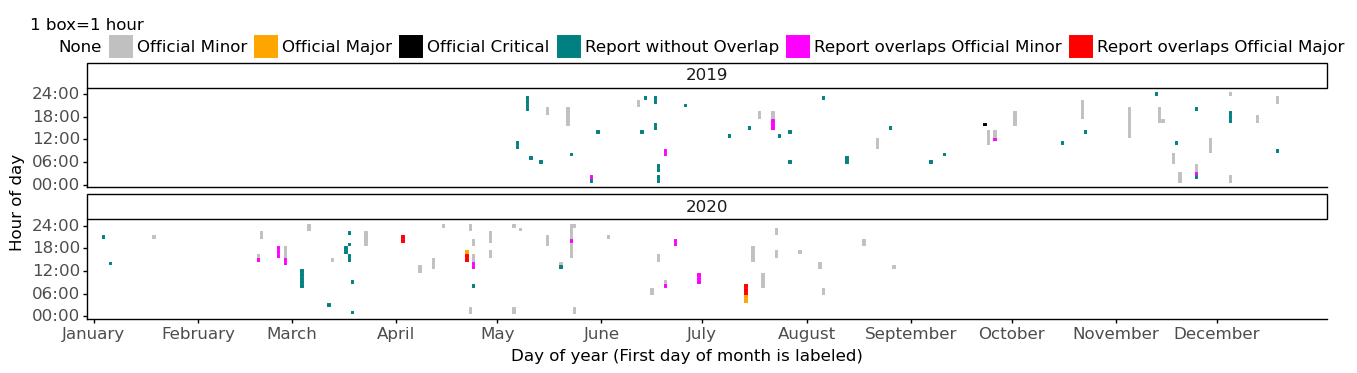

<ggplot: (326423902)>

In [38]:
plt = ggplot(merged_df) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    geom_tile(mapping=aes(x='day_of_year', y='hour_of_day', fill='status'), color='white', size=0.02) +\
    scale_fill_manual(values=['white', 'silver', 'orange', 'black', 'teal', 'magenta', 'red'],
                      labels=['None', 'Official Minor', 'Official Major', 'Official Critical', 'Report without Overlap', 'Report overlaps Official Minor', 'Report overlaps Official Major']) +\
    scale_x_continuous(limits=(first_day_of_month[0], first_day_of_month[-1]), expand=(0.005, 0.005),
                       breaks=first_day_of_month[:-1],
                       labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']) +\
    scale_y_continuous(breaks=[0, 6, 12, 18, 24],
                       labels=['00:00', '06:00', '12:00', '18:00', '24:00']) +\
    theme(figure_size=(16, 3)) +\
    guides(fill=guide_legend(title='1 box=1 hour', nrow=1)) +\
    facet_wrap(facets='year', nrow=2) +\
    ylab('Hour of day') +\
    xlab('Day of year (First day of month is labeled)') +\
    theme(legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          legend_position='top',
          text=element_text(size=12))

plt.save('plots/double_github_merged_failures.pdf', limitsize=False)
plt